In [1]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Spark session

In [2]:
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("DescriptiveAnalysis")\
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','32G') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

sc=spark.sparkContext

### Read the data 

In [3]:
rdd= sc.textFile('../../Dataset/val-RDD.csv')
header= rdd.first()
rdd= rdd.filter(lambda x: x!=header)

rdd.take(5)

['Q ParentConnection,com.AequitasSolutions.ParentPortal,Education,3.1,71.0,10000+,10000,36999,True,0.0,USD,24M,4.1 and up,Aequitas Solutions  Inc.,https://www.myaequitas.com,info@myaequitas.com,Jul 3  2019,Jun 11  2020,Everyone,https://www.myaequitas.com/privacy.aspx,False,False,False,2021-06-15 23:58:57',
 'Chef Monkey Pet - Adopt me,chef.monkeypet.co,Adventure,2.4,14.0,500+,500,614,True,0.0,USD,40M,4.1 and up,ALPHAEGO,,anasseb63@gmail.com,Apr 6  2021,Apr 06  2021,Everyone,,True,False,False,2021-06-16 06:39:57',
 'SmartConnect Apps,com.logictree.smartconnectapps,Productivity,0.0,0.0,100+,100,107,True,0.0,USD,10M,4.1 and up,LogicTree IT Solutions Inc,http://logictreeit.com,logictreeitsolutions@gmail.com,Sep 15  2017,Aug 19  2019,Everyone,https://www.smartconnectapps.com/OP/smartconnectappscom/terms.html,True,False,False,2021-06-16 12:18:18',
 'Team Formula Pro (2021),uk.co.teambobk.f1calendar,Sports,4.7,86.0,1000+,1000,1004,False,3.49,USD,9.5M,5.0 and up,TeamBobK,http://www.teambobk.co

# Avg Installations/ Free-Paid Apps

In [4]:
# total_apps= rdd.count()
# free_apps= rdd.filter(lambda x: x.split(',')[8] == 'True').count()
# paid_apps= rdd.filter(lambda x: x.split(',')[8] == 'False').count()

# print(f'Number of Free apps: {free_apps}')
# print(f'Number of Paid apps: {paid_apps}')
# print(f'Total Number of apps: {total_apps}')

Number of Free apps: 453626
Number of Paid apps: 8963
Total Number of apps: 462589


In [ ]:
# import numpy as np
# def avg_installs(x):
#     max_installations = x.split(',')[7]
#     min_installations= x.split(',')[6]

#     if x.split(',')[8] == 'True': return ('Free',(max_installations,min_installations))
#     else:                         return ('Paid',(max_installations,min_installations))

# avg_installs_paid = rdd.filter(lambda x:x!='')\
#                 .map(avg_installs)\
#                 .mapValues(lambda x: np.ceil((int(x[0])+int(x[1]))/2))\
#                 .mapValues(lambda x: int(x))\
#                 .reduceByKey(lambda x, y: x + y)\
#                 # .map(lambda x: (x[0], x[1] / free_apps if x[0] == 'Free' else x[1] / paid_apps))
                
# avg_installs_paid.take(2)

# Avg/ Max price for each category

In [25]:
#1. we map each row to a tuple of (category, price)
#2. we map each value to a tuple of (price, 0, price) --> (sum of price, count of each category, max price) 
#3. we aggregate by key, summing up the values of each category, 
#   counting the number of each category, and getting the max price of each category
#4. we map each value to a tuple of (avg price, count of each category, max price)
#5. we map each row to a tuple of (category, (count of each category, avg price, max price))
#6. we sort by count of each category in descending order

price = rdd.filter(lambda x: x.split(',')[2] != '' and x.split(',')[9]!='') \
        .map(lambda x: (x.split(',')[2], x.split(',')[9])) \
        .mapValues(lambda x: (float(x), 0, float(x))) \
        .aggregateByKey((0.0, 0, 0), 
                         lambda acc, value: (acc[0] + value[0], acc[1] + 1, max(acc[2], value[0])), # addOp then combOp
                         lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1], max(acc1[2], acc2[2]))) \
        .mapValues(lambda x: (x[0] / x[1], x[1], x[2])) \
        .map(lambda x: (x[0], ( x[1][1], x[1][0], x[1][2])))\
        .sortBy(lambda x: x[1][0], ascending=False) 

price.collect()

[('Education', (48276, 0.1550999405087413, 354.99)),
 ('Music & Audio', (31067, 0.05294917697235013, 399.99)),
 ('Tools', (28888, 0.17328381798670747, 399.99)),
 ('Business', (28523, 0.04460879865371807, 149.99)),
 ('Entertainment', (27607, 0.06937293077842582, 399.99)),
 ('Lifestyle', (23652, 0.07277472230678171, 399.99)),
 ('Books & Reference', (23403, 0.20062015027987887, 399.99)),
 ('Personalization', (17920, 0.10030513214285751, 23.99)),
 ('Health & Fitness', (16788, 0.10257455587324289, 99.99)),
 ('Productivity', (15928, 0.17388843156705186, 400.0)),
 ('Shopping', (15180, 0.0024365395915678526, 12.106671)),
 ('Food & Drink', (14807, 0.01749848044843655, 99.99)),
 ('Travel & Local', (13522, 0.0744922746635114, 24.46)),
 ('Finance', (13119, 0.06612080844576569, 80.575483)),
 ('Arcade', (10843, 0.09328434990316335, 329.99)),
 ('Casual', (10194, 0.0830322392583873, 399.99)),
 ('Puzzle', (10133, 0.06589112918188099, 29.99)),
 ('Communication', (9658, 0.04275419341478567, 27.99)),
 ('S

# Max No. of Installs for each category

In [26]:
# max installs= x[7], category= x[2]

max_installs_categ= rdd.filter(lambda x:x.split(',')[2]!='' and x.split(',')[7]!='')\
            .map(lambda x: (x.split(',')[2], x.split(',')[7]))\
            .mapValues(lambda x: int(x))\
            .reduceByKey(lambda x,y:(x+y))\
            .sortBy(lambda x: x[1], ascending=False)


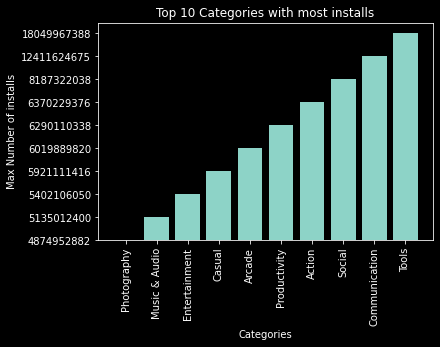

In [26]:
# plot the top 10 categories with most installs
top_10_categ= max_installs_categ.take(10)
top_10_categ= np.array(top_10_categ)
top_10_categ= np.flip(top_10_categ, axis=0)

plt.style.use('dark_background')
plt.xticks(rotation=90)
plt.bar(top_10_categ[:,0], top_10_categ[:,1])
plt.title('Top 10 Categories with most installs')
plt.xlabel('Categories')
plt.ylabel('Max Number of installs')
plt.show()

# Min No. of Installs for each category

In [27]:
#TODO: check if this analysis is important or not
# TYPO: in filter
# min installs= x[6], category= x[2]
min_installs_categ= rdd.filter(lambda x:x.split(',')[2]!='' and x.split(',')[6]!='')\
            .map(lambda x: (x.split(',')[2], x.split(',')[6]))\
            .filter(lambda x: x[1].isdigit()) \
            .mapValues(lambda x: int(x))\
            .reduceByKey(lambda x,y: x+y)\
            .sortBy(lambda x: x[1], ascending=True)


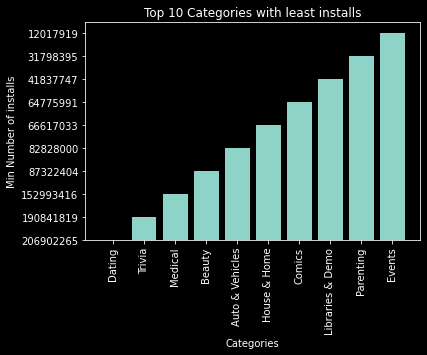

In [24]:
# plot the top 10 categories with most installs
top_10_categ= min_installs_categ.take(10)
top_10_categ= np.array(top_10_categ)
top_10_categ= np.flip(top_10_categ, axis=0)

plt.style.use('dark_background')
plt.xticks(rotation=90)
plt.bar(top_10_categ[:,0], top_10_categ[:,1])
plt.title('Top 10 Categories with least installs')
plt.xlabel('Categories')
plt.ylabel('Min Number of installs')
plt.show()

# Average app size for each category

In [ ]:
# avg_app_size= rdd.filter(lambda x:x!='')\
#             .map(lambda x: (x.split(',')[2], x.split(',')[11]))

# avg_app_size.take(500)

# Developed apps per developer

In [22]:
# TODO: make the key be: developer id, developer website & developer email

developer_apps= rdd.filter(lambda x:x.split(',')[13]!='')\
                .map(lambda x: (x.split(',')[13], 1))\
                .reduceByKey(lambda x,y:(x+y))\
                .sortBy(lambda x: x[1], ascending=False)

top_developer_apps= np.array(developer_apps.collect())

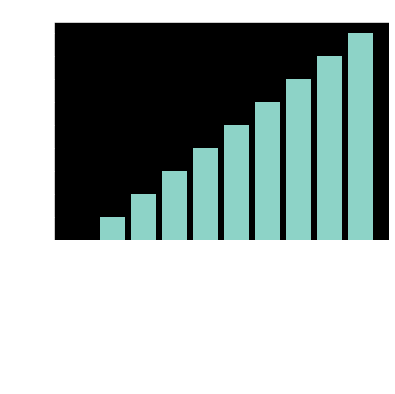

In [5]:
#plot the top 10 developers with most apps 
top_10_developers= top_developer_apps[:10]
top_10_developers= np.array(top_10_developers)
top_10_developers= np.flip(top_10_developers, axis=0)

plt.style.use('dark_background')
plt.xticks(rotation=90)
plt.bar(top_10_developers[:,0], top_10_developers[:,1])
plt.title('Top 10 Developers with most apps')
plt.xlabel('Developers')
plt.ylabel('Number of apps')
plt.show()


### Ratings

In [6]:
ratings= rdd.filter(lambda x: x.split(',')[3] != '')\
        .map(lambda x: (int(np.floor(float(x.split(',')[3]))), 1))\
        .reduceByKey(lambda x,y:(x+y))

ratings_arr= np.array(ratings.collect())

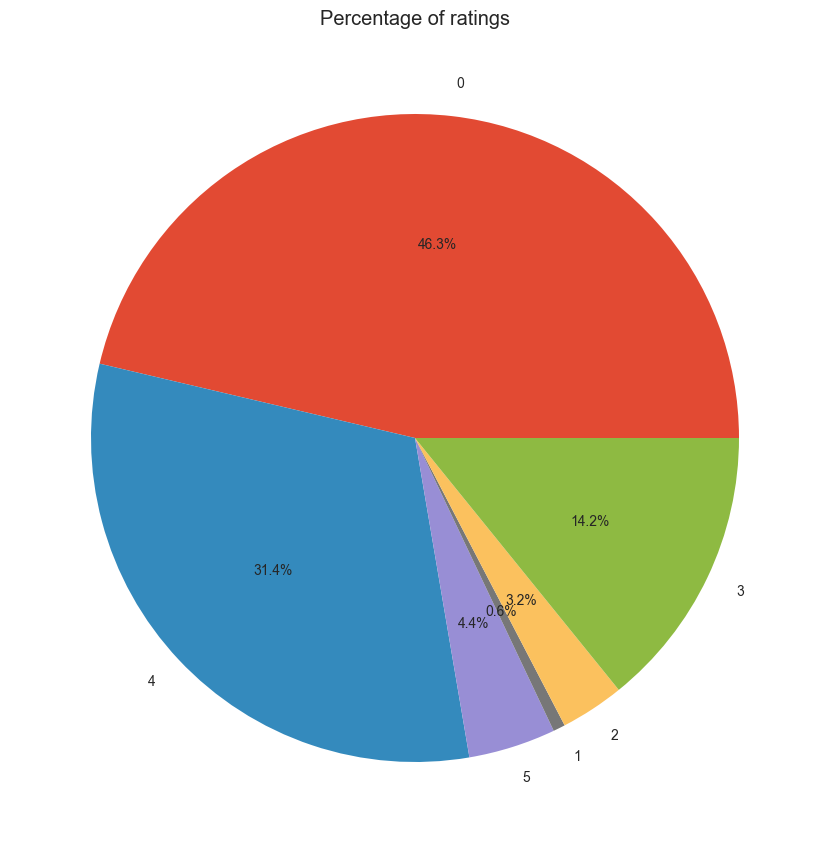

'\nThis shows that most of the users do not rate the apps, and when they do their ratings are usually between 4-5.\n'

In [18]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use("ggplot")
plt.pie(ratings_arr[:,1], labels=ratings_arr[:,0], autopct='%1.1f%%')
plt.title('Percentage of ratings')
plt.show()

'''
This shows that most of the users do not rate the apps, and when they do their ratings are usually between 4-5.
'''

### Highest rated Category


In [34]:
categ_rate= rdd.filter(lambda x: x.split(',')[2] != '' and x.split(',')[3] != '')\
        .map(lambda x: (x.split(',')[2], x.split(',')[3]))\
        .mapValues(lambda x: (float(x), 1))\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .mapValues(lambda x: x[0]/x[1])\
        .sortBy(lambda x: x[1], ascending=True)

categ_rate_arr= np.array(categ_rate.collect())


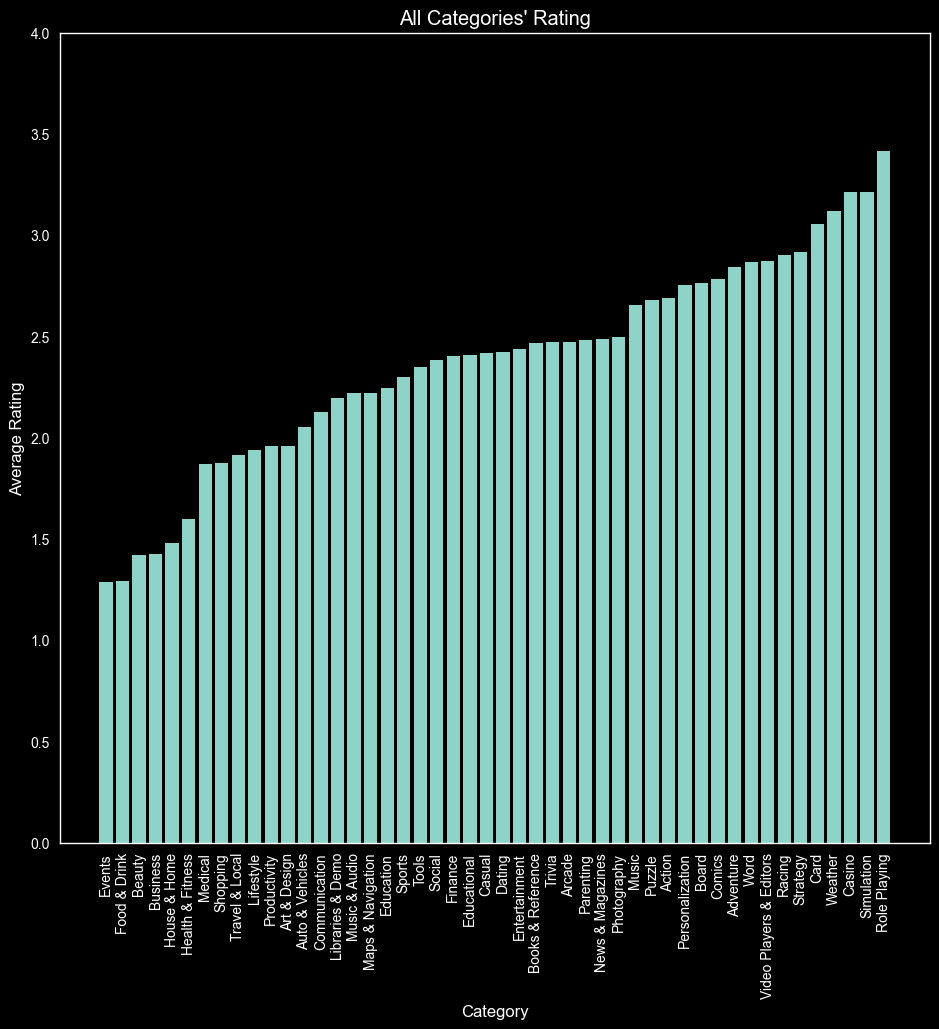

In [38]:
categories = [x[0] for x in categ_rate.collect()]
ratings = [x[1] for x in categ_rate.collect()]

plt.style.use('dark_background')
plt.grid(False)
plt.bar(categories, ratings)
plt.ylim(0, 4)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.title("All Categories' Rating")
plt.show()

### top 10 Categories that are installed
### Category has the highest Paid and Free Apps
### top 5 Paid Apps based with highest ratings and Installs
### top 5 Free Apps based with highest ratings and Installs
### developers with highest rates
### top 5 cats of free and paid apps
### top 5 cats of paid apps based on the rating